In [1]:
#@title Upgrade to TensorFlow 2.1+
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.0)


In [2]:
#@title Install Libraries for this colab
!pip install scipy
!pip install matplotlib
!pip install --upgrade Quandl

import seaborn as sns
import tensorflow as tf

# Load utility to save the graph in a tensorboard-friendly way
from tensorflow.python.summary.writer.writer import FileWriter
from PIL import Image
%load_ext tensorboard

In [3]:
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import quandl

import tensorflow as tf
import tensorflow_probability as tfp

plt.rcParams['figure.figsize'] = [20, 10]

Inputs, timeseries

In [4]:
rhp              = 1
rhp_days         = 250 * rhp
nr_simulations   = 10000
r_riskfree       = 0

notional         = 1000.0
coupon           = 0.06
relative_barrier = 0.9
relative_strike  = 1.0

In [7]:
df = quandl.get(["SIX/CH0038863350CHF","SIX/CH0012005267CHF","SIX/CH0012032048CHF"], start_date=dt.datetime(2017,6,1), end_date=dt.datetime(2020,6,1), api_key="5GuPDNsCcpzrDwvsyyaz") 
df = df[df.columns.drop(list(df.filter(regex='Volume')))]

In [8]:
prices = tf.constant(df.T, name="prices")
s_0    = prices[:,0]

barrier = tf.math.scalar_mul(relative_barrier, s_0)
strike  = tf.math.scalar_mul(relative_strike, s_0)
ratio   = tf.math.scalar_mul(notional, 1/s_0)

nr_underlyings = prices.shape[0]

Returns per underlying

In [9]:
returns = tf.math.log(tf.divide(prices[:,1:],prices[:,:-1]))

Resampling of returns

In [10]:
def resample(matrix, rhp_days, nr_simulations):
    indices = tf.random.uniform(shape=(rhp_days*nr_simulations,), maxval=matrix.shape[1], dtype=tf.int32)
    bootstrap = tf.gather(matrix, indices, axis=1)
    return tf.reshape(bootstrap, shape=(matrix.shape[0], rhp_days, nr_simulations))

In [11]:
resamples = resample(returns, rhp_days, nr_simulations)

Moments

In [12]:
def moments(v):
    m0 = tf.broadcast_to(tf.constant(v.shape[1], dtype=tf.float64), shape=(v.shape[0],))
    m1 = tf.divide(tf.reduce_sum(v, axis=1), m0)
  
    w = tf.add(v,-tf.transpose(tf.broadcast_to(m1, (v.shape[1], v.shape[0])), perm=[1,0]))

    m2 = tf.divide(tf.reduce_sum(tf.pow(w,2), 1), m0)
    m3 = tf.divide(tf.reduce_sum(tf.pow(w,3), 1), m0)
    m4 = tf.divide(tf.reduce_sum(tf.pow(w,4), 1), m0)

    sigma = tf.sqrt(m2)

    return (m1,m2,m3,m4,sigma)

In [13]:
(m1,m2,m3,m4,sigma) = moments(returns)

Simulation Paths

$$s_0 \times e^{\sum_{i=0}^k {r_i} + k(r_{rf}-0.5\sigma^2)}$$

In [14]:
cumsum = tf.map_fn(tf.math.cumsum, tf.transpose(resamples, perm=[2,0,1]))
k      = tf.broadcast_to(tf.range(0, limit=rhp_days, dtype=tf.float64), (nr_simulations, nr_underlyings, rhp_days))

def broadcast_and_transpose(x):
  return tf.transpose(tf.broadcast_to(x, (nr_simulations, rhp_days, nr_underlyings)), perm=[0,2,1])

minus_half_sigma_sqrt = broadcast_and_transpose(tf.math.scalar_mul(-0.5, tf.math.square(sigma)))
s0                    = broadcast_and_transpose(s_0)

paths = tf.math.multiply(s0, tf.exp(tf.math.add(cumsum, tf.math.multiply(k, minus_half_sigma_sqrt))))

Payoff

In [15]:
def payoff_brc(sim):
  last = sim[:,-1]
  
  def cap(): return notional*(1+coupon)
  def worst(): return tf.reduce_min(tf.math.multiply(ratio, last))
  def payoff_rc(): return tf.cond(tf.reduce_all(tf.less(strike, last)), cap, worst)
  def knocked_in(): return tf.reduce_any(tf.math.less(tf.reduce_min(sim, axis=1), barrier))

  return tf.cond(knocked_in(), payoff_rc, cap)

In [16]:
payoff = tf.map_fn(payoff_brc, paths)

Stats

In [17]:
def vev(p): return (np.sqrt(3.842 - 2*np.log(p)) - 1.96) / np.sqrt(rhp)

In [18]:
def mrm(v): 
    if   (               v < 0.005) : m = 1
    elif (v >= 0.005 and v < 0.05)  : m = 2
    elif (v >= 0.05  and v < 0.12)  : m = 3
    elif (v >= 0.12  and v < 0.2)   : m = 4
    elif (v >= 0.2   and v < 0.3)   : m = 5
    elif (v >= 0.3   and v < 0.8)   : m = 6
    else:                             m = 7
    return m

In [19]:
VaR = tfp.stats.percentile(payoff, 2.5)/notional
VEV = vev(VaR)
MRM = mrm(VEV)

print("VaR: %f" % VaR)
print("VEV: %f" % VEV)
print("MRM: %d" % MRM)

VaR: 0.922278
VEV: 0.040954
MRM: 2


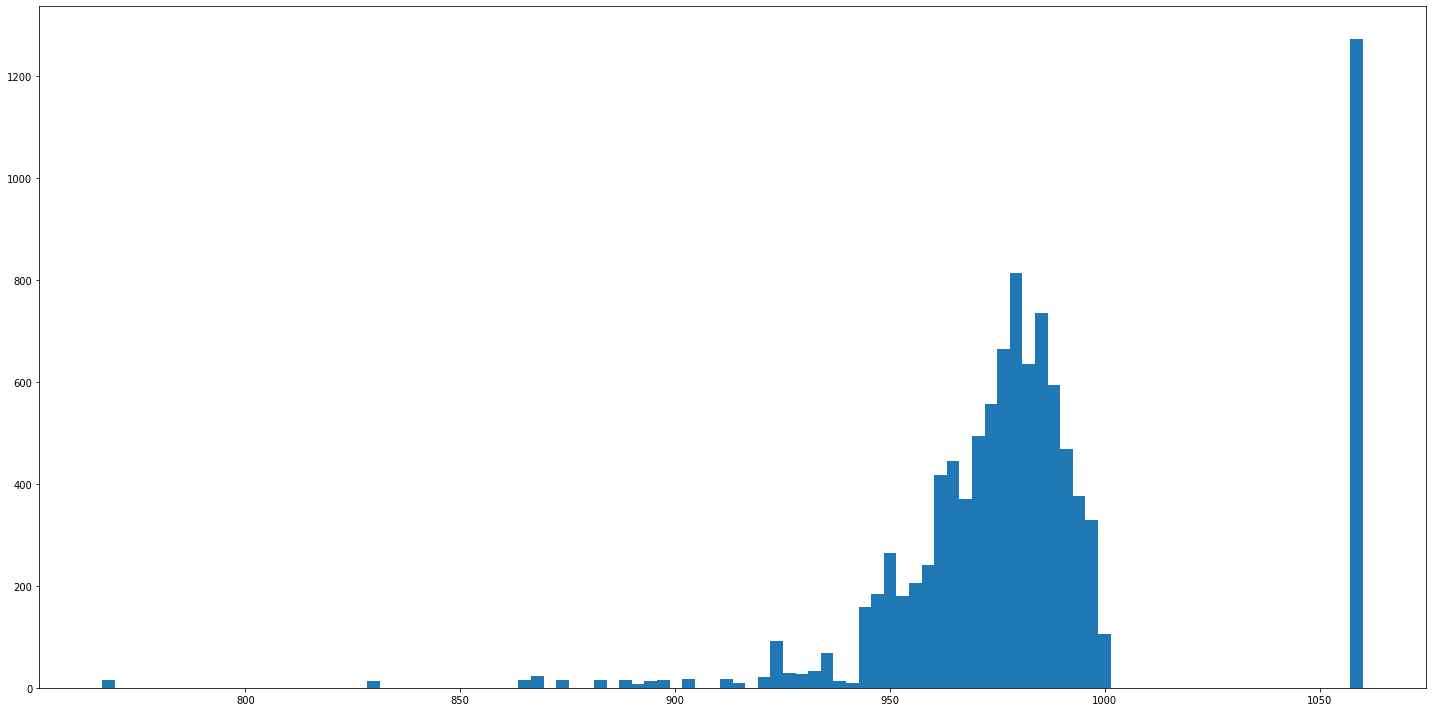

In [20]:
fig, axs = plt.subplots(1, 1, tight_layout=True)
_ = axs.hist(payoff, bins=100)